In [1]:
using Profile
using PProf
using Plots
using Distributions
include("zipf.jl")

mutable struct quant_OGD_integral{TP<:Integer,TC<:UInt8} # TP = Type Pointer, TC = Type Counter
    const C_UPPER::TP
    const CACHE_FLAG::Bool # activates tracking cache operations 
    cache::Set{TP} # pointers of the cache, this is not needed but handy
    cache_size::TP # tracks the current cache size

    const ONE::TC
    lazy_update::TC
    step_size::TC
    count::TC # for count lookup and calculation
    d::TC # for putting the d calculation
    u::TC # for uniform lookup 

    counter_uniform::Dict{TP,Tuple{TC,TC}} # pointer -> (counter, uniform)
    d_look::Dict{TC,Set{TP}} # d -> set of pointers with this d
    val_look::Dict{TC,Set{TP}} # counter -> set of pointers with this counter
end


function Base.show(io::IO, q::quant_OGD_integral)
    println(io, "QuantOGD Parameters:")
    println(io, "-------------------------")
    println(io, "C_UPPER:    ", q.C_UPPER)
    println(io, "CACHE_FLAG:    ", q.CACHE_FLAG)
    println(io, "cache:   ", q.cache)
    println(io, "Cache Size: ", q.cache_size)

    println(io, "ONE:        ", q.ONE)
    println(io, "Lazy Update: ", q.lazy_update)
    println(io, "Step Size:  ", q.step_size)
    println(io, "Counter:    ", q.count)
    println(io, "d:          ", q.d)
    println(io, "u:          ", q.u)

    println(io, "counter_uniform: ", q.counter_uniform)
    println(io, "d_look:     ", q.d_look)
    println(io, "val_look:   ", q.val_look)
    println(io, "-------------------------")
end


# Constructor for quantOGD
function init_quant_OGD_integral(;
    C=10,
    step_size=1,
    CACHE_FLAG=false,
    TP::Type{<:Integer}=UInt64,
    TC::Type{<:UInt8}=UInt8
)
    C_UPPER = TP(C)
    CACHE_FLAG = CACHE_FLAG
    cache = Set{TP}() # 1 ptr / nonzero item if CACHE_FLAG 
    cache_size = zero(C_UPPER)

    ONE = TC(typemax(TC))
    lazy_update = zero(ONE)
    step_size = TC(step_size)
    count = zero(ONE)  # maybe we should init to nothing? 
    d = zero(ONE)
    u = zero(ONE)

    counter_uniform = Dict{TP,Tuple{TC,TC}}() # 1 ptr & 2 counters (UInt8) /nonzero item
    d_look = Dict(TC(i) => Set{TP}() for i in 0:ONE) # 1 ptr & 1 counter /nonzero item 
    val_look = Dict(TC(i) => Set{TP}() for i in 0:ONE) # 1 ptr & 1 counter / nonzero item
    # we conjecture that d_look and val_look can be combined so in total we can have 2 ptrs / nonzero item

    return quant_OGD_integral{TP,TC}(C_UPPER, CACHE_FLAG, cache, cache_size, ONE, lazy_update, step_size, count, d, u, counter_uniform, d_look, val_look)
end

function in_cache(q::quant_OGD_integral, i::Integer)
    return (
        (i in q.d_look[q.lazy_update]) || # here are pointers waited to be evicted
        (haskey(q.counter_uniform, i) && # counter is nonzero
         q.counter_uniform[i][1] - q.lazy_update > q.counter_uniform[i][2]) # d>0
    )
end

# removes old info in d_look and val_look of i
function remove_look!(q::quant_OGD_integral, i::Integer)
    if haskey(q.counter_uniform, i) # count[i] is non zero
        q.count, q.u = q.counter_uniform[i]
        delete!(q.val_look[q.count], i)
        if q.count - q.lazy_update > q.u # d>0 
            q.d = q.count - q.u
            delete!(q.d_look[q.d], i)
            q.CACHE_FLAG && delete!(q.cache, i)
            q.cache_size -= one(q.cache_size)
        end
    end
end

# updates d_look and val_look with new info of i
function update_look!(q::quant_OGD_integral, i::Integer)
    push!(q.val_look[q.count], i)
    if q.count - q.lazy_update > q.u # checks if d>0 
        q.d = q.count - q.u
        push!(q.d_look[q.d], i)
        if !(i in q.d_look[q.lazy_update])
            q.CACHE_FLAG && push!(q.cache, i)
            q.cache_size += one(q.cache_size)
        else
            delete!(q.d_look[q.lazy_update], i)
        end
    end
end

# tries to cache i if there is space, used to initialize the cache 
function try_cache!(q::quant_OGD_integral, i::Integer)
    if q.cache_size < q.C_UPPER && !(in_cache(q, i))
        push!(q.d_look[q.lazy_update], i)
        q.CACHE_FLAG && push!(q.cache, i)
        q.cache_size += one(q.cache_size)
    end
end



function cache_resize!(q::quant_OGD_integral)
    while q.cache_size > q.C_UPPER
        if !isempty(q.d_look[q.lazy_update])
            q.CACHE_FLAG ? delete!(q.cache, pop!(q.d_look[q.lazy_update])) : pop!(q.d_look[q.lazy_update])
            q.cache_size -= one(q.cache_size)
        else
            q.lazy_update += one(q.lazy_update)
            # (q.lazy_update == 0) && println("lazy update is 0")
            delete!.(Ref(q.counter_uniform), q.val_look[q.lazy_update]) # deletes all 0 counters from the dict
            empty!(q.val_look[q.lazy_update])
        end
    end
end

function step!(q::quant_OGD_integral, i::Integer)
    remove_look!(q, i) # removes old info in val/d_look of i
    # updating count and uniform
    if haskey(q.counter_uniform, i) # count[i] is non zero
        # + step size will be bigger then 1 in mod 2^l
        q.count = (q.ONE - q.step_size >= q.count - q.lazy_update) ? q.count + q.step_size : q.lazy_update + q.ONE
    else
        q.count = q.lazy_update + q.step_size
        q.u = rand(one(q.ONE):q.ONE) # ceiling the uniform so it starts at 1 
        #  always updating q.u requires other control flow
    end
    q.counter_uniform[i] = (q.count, q.u)
    update_look!(q, i) # updates new info in val/d_look of i
    try_cache!(q, i) # tries to cache i if there is space
    cache_resize!(q) # does a cache resize
end


get_fraction(q::quant_OGD_integral, i) = (haskey(counter_uniform, i)) ? (q.counter[i][1] - q.lazy_update) / q.ONE : 0

function zipf_setup(; T=10^5, N=10^4, alpha=1.0, C=div(10^4, 20), CACHE_FLAG=false, step_size=0)
    zipf = ZipfSampler(alpha, N)
    zipf_trace = [sample(zipf) for _ in 1:T]
    step_size = UInt8(step_size)
    if (step_size == 0)
        step_size_real = sqrt(C * (1 - C / N) / T)
        step_size = clamp(UInt8(floor(step_size_real * 255)), 1, 10) # high stepsizes make the cache change much which is expensive
    end
    println("step_size: ", step_size)
    q = init_quant_OGD_integral(C=C, step_size=step_size, CACHE_FLAG=CACHE_FLAG)
    return q, zipf_trace
end

zipf_setup (generic function with 1 method)

In [15]:
function test_init_quant_OGD()
    q = init_quant_OGD_integral(C=50,step_size = UInt8(10))
    ii = repeat(UInt32(0):UInt32(999),10)
    for i in ii
        step!(q, i)
    end
    cache = Set()
    for (_, s) in q.d_look
        union!(cache,s)
    end
    println(q)
    println("length of cache: ",length(cache))
    println("calculated cache: ",cache)
end
test_init_quant_OGD()

QuantOGD Parameters:
-------------------------
C_UPPER:    50
CACHE_FLAG:    false
cache:   Set{UInt64}()
Cache Size: 50
ONE:        255
Lazy Update: 84
Step Size:  10
Counter:    100
d:          99
u:          1
counter_uniform: Dict{UInt64, Tuple{UInt8, UInt8}}(0x00000000000002cf => (0x64, 0x28), 0x00000000000002bb => (0x64, 0xf5), 0x000000000000033f => (0x64, 0xe7), 0x000000000000013f => (0x64, 0xc2), 0x00000000000002af => (0x64, 0xfa), 0x00000000000000b9 => (0x64, 0x3f), 0x0000000000000337 => (0x64, 0x3a), 0x00000000000001a4 => (0x64, 0xe5), 0x000000000000020d => (0x64, 0x59), 0x000000000000016d => (0x64, 0x09), 0x000000000000027e => (0x64, 0xc8), 0x0000000000000107 => (0x64, 0x69), 0x00000000000001a6 => (0x64, 0x48), 0x00000000000000f2 => (0x64, 0xc6), 0x00000000000000b7 => (0x64, 0x21), 0x0000000000000227 => (0x64, 0xcb), 0x00000000000000e0 => (0x64, 0x27), 0x00000000000002b6 => (0x64, 0x01), 0x00000000000002b4 => (0x64, 0xbc), 0x00000000000000b1 => (0x64, 0xbc), 0x00000000000002

In [4]:

function test_time(; T=10^5, N=10^4, alpha=1.0, C=div(10^4, 20),CACHE_FLAG = false)
    q, zipf_trace = zipf_setup(T=T, N=N, alpha=alpha, C=C, CACHE_FLAG = CACHE_FLAG)
    println("N: $N, C: $C, T:$T")
    @time begin
        for j in zipf_trace
            step!(q, j)
        end
    end
end
N = 10^4
C = div(N, 20)
test_time(T=10^7, N=N, alpha=0.6, C=C, CACHE_FLAG = false)

N = 10^5
C = div(N, 20)
test_time(T=10^7, N=N, alpha=0.6, C=C, CACHE_FLAG = false)

N = 10^6
C = div(N, 20)
test_time(T=10^7, N=N, alpha=0.6, C=C, CACHE_FLAG = false)



step_size: 1
N: 10000, C: 500, T:10000000
  2.474675 seconds (25.86 k allocations: 104.452 MiB)
step_size: 5
N: 100000, C: 5000, T:10000000
  5.295120 seconds (25.25 k allocations: 122.680 MiB, 6.67% gc time)
step_size: 10
N: 1000000, C: 50000, T:10000000
  6.816119 seconds (28.32 k allocations: 301.739 MiB, 4.41% gc time)


In [ ]:
N = 10^8
C = div(N, 20)
# test_time(T=10^8, N=N, alpha=0.6, C=C, CACHE_FLAG = false)

step_size: 10
N: 100000000, C: 5000000, T:100000000
 72.761173 seconds (364.00 k allocations: 5.038 GiB, 1.75% gc time)


In [4]:
function profile(; T=10^5, N=10^4, alpha=1.0, C=div(10^4, 20),CACHE_FLAG= false)
    q, zipf_trace = zipf_setup(T=T, N=N, alpha=alpha, C=C, CACHE_FLAG = CACHE_FLAG)
    Profile.clear()
    @pprof begin
        for j in zipf_trace
            step!(q, j)
        end
    end
    pprof(web = true, webhost = "localhost", webport = 57599)
end
N = 10^6
C = div(N, 20)
profile(T=10^7, N=N, alpha=0.8, C=C, CACHE_FLAG = false)

step_size: 10


"profile.pb.gz"

Main binary filename not available.
Serving web UI on http://localhost:57599


In the profile, removing and updating info in the lookup sets dominates. There are still some ways to make this faster without going concurrent on the requests:
removing and updating the info can be done concurrently, deletes and pushes from the cache set aren't required, by combining the val_look and d_look max only 1 delete and 1 push has to happen and using a custom implementation for the set data structure will help (maybe even approximations like bloom filters). 

![profile](imgs/profile_qOCDmod.png)

In [66]:

function profile_alloc(; T=10^5, N=10^4, alpha=1.0, C=div(10^4, 20),CACHE_FLAG = false)
    q, zipf_trace = zipf_setup(T=T, N=N, alpha=alpha, C=C, CACHE_FLAG = CACHE_FLAG)
    Profile.Allocs.clear()
    Profile.Allocs.@profile begin
        for j in zipf_trace
            step!(q, j)
        end
    end
    PProf.Allocs.pprof(web = true, webhost = "localhost", webport = 57599)
end

N = 10^5
C = div(N, 20)
profile_alloc(T=10^6, N=N, alpha=0.8, C=C, CACHE_FLAG = false)

Main binary filename not available.
Serving web UI on http://localhost:57599


step_size is capped at 10 for performance reasons
step_size: 10


Analyzing 782 allocation samples... 100%|████████████████| Time: 0:00:02


"alloc-profile.pb.gz"

C=500
step_size: 1


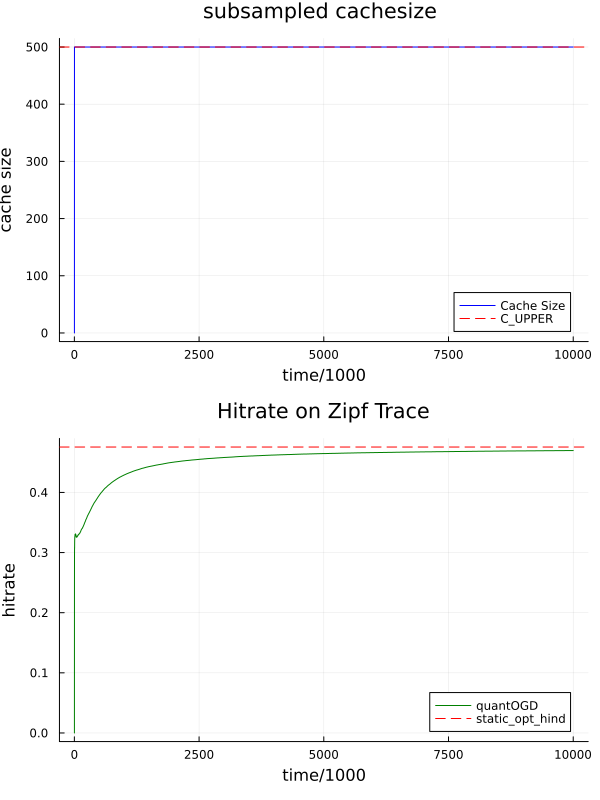

In [17]:
function zipf_hitrate_plt(; T=10^5, N=10^4, alpha=1.0, C=div(10^4, 20), step_size = 0)
    q, zipf_trace = zipf_setup(T=T, N=N, alpha=alpha, C=C, CACHE_FLAG = true, step_size = step_size)
    hit = 0.0
    hits = zeros(Float32, length(zipf_trace))
    cachesizes = zeros(Float32, length(zipf_trace))

    for i in 1:length(zipf_trace)
        j = zipf_trace[i]
        hit += (j in q.cache) ? 1 : 0
        hits[i] = hit
        cachesizes[i] = length(q.cache)
        step!(q, j)
    end
    ss = div(length(hits), 10^4)  # this for subsampling  
    # Compute the moving maximum over the cachesizes array using the specified window.
    # mov_max = [maximum(cachesizes[max(1, i - window + 1):i]) for i in 1:length(cachesizes)]

    # First plot: moving maximum of the cache sizes.
    p1 = plot(cachesizes[1:ss:end],
        label="Cache Size",
        color=:blue,
        xlabel="time/$ss",
        ylabel="cache size",
        title="subsampled cachesize ")
    hline!(p1, [q.C_UPPER],
        label="C_UPPER",
        color=:red,
        linestyle=:dash)

    # Calculate opt (static optimal hitrate)
    opt = mean(zipf_trace .<= C)
    # Generate the decay curve: cumulative hitrate over time.
    decay_curve = hits ./ (1:length(zipf_trace))

    # Second plot: hitrate decay curve.
    p2 = plot(decay_curve[1:ss:end],
        label="quantOGD",
        color=:green,
        xlabel="time/$ss",
        ylabel="hitrate",
        title="Hitrate on Zipf Trace")
    hline!(p2, [opt],
        label="static_opt_hind",
        color=:red,
        linestyle=:dash)

    # Stack the two plots vertically.
    p = plot(p1, p2, layout=(2, 1), size=(600, 800))
    display(p)
end

N = 10^4
C = div(N, 20)
println("C=",C)
zipf_hitrate_plt(T=10^7, N=N, alpha=0.8, C=C, step_size= 0)

C=2000
step_size: 3


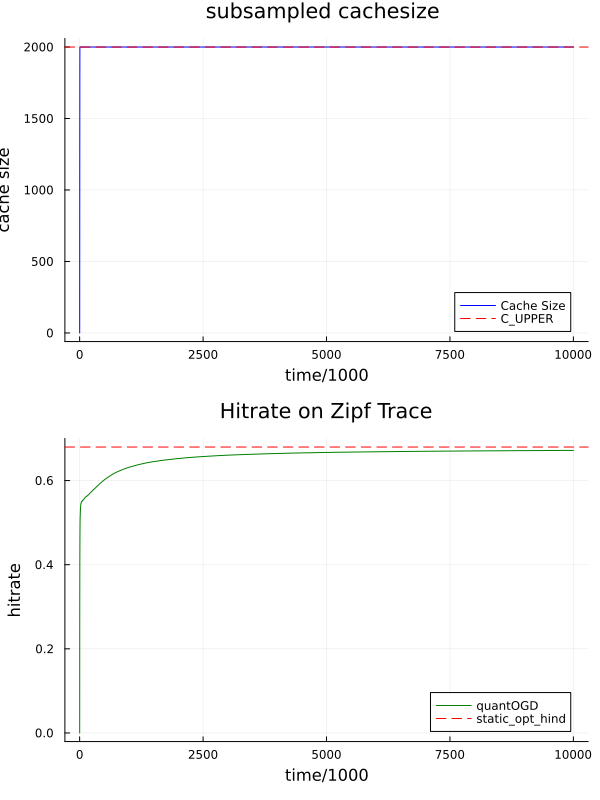

In [6]:
N = 10^4
C = div(N, 5)
println("C=",C)
zipf_hitrate_plt(T=10^7, N=N, alpha=0.8, C=C)

C=20000
step_size: 10


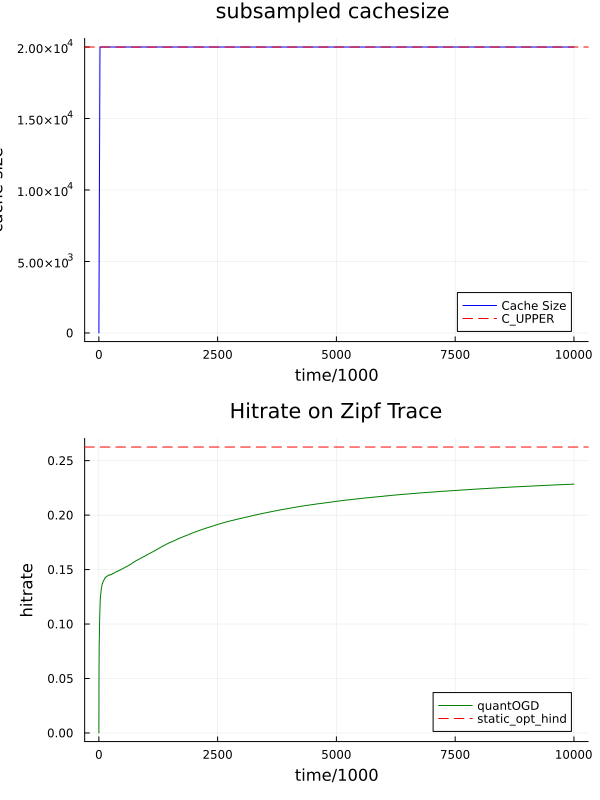

In [7]:
N = 10^7
C = div(N, 500)
println("C=",C)
zipf_hitrate_plt(T=10^7, N=N, alpha=0.8, C=C)

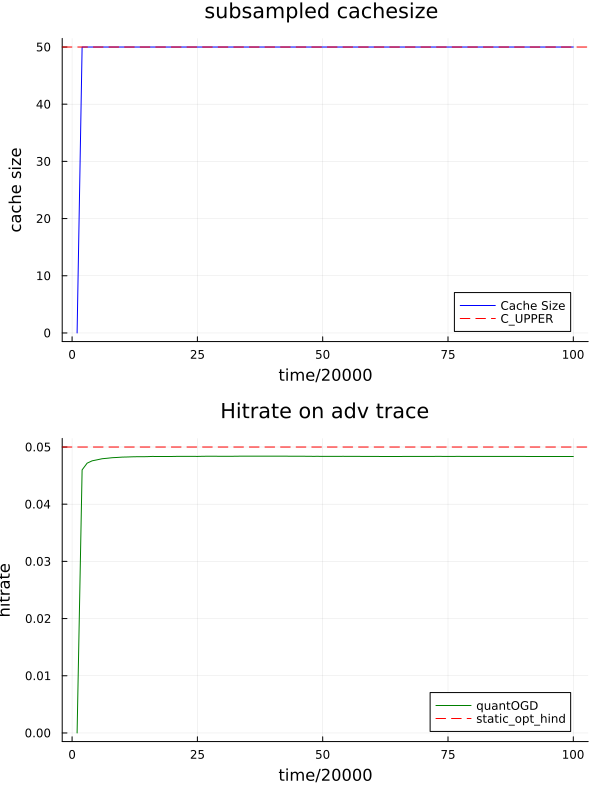

step_size: 1
final hitrate:0.0483335


In [9]:
using Random
function adv_hitrate_plt(; rep= 1000, alpha=1.0, C=500, window=1000)

    tmp = collect(1:1000)
    l = [] 
    for _ in 1:rep
        append!(l,shuffle(tmp))
    end
    l = [ Int(x) for x in l]

    T = length(l)
    N = 1000
    hit = 0.0
    hits = zeros(Float32, length(l))
    cachesizes = zeros(Float32, length(l))

    q, zipf_trace = zipf_setup(T=T, N=N, alpha=alpha, C=C, CACHE_FLAG = true)

    for i in 1:length(l)
        j = l[i]
        hit += (j in q.cache) ? 1 : 0
        hits[i] = hit
        cachesizes[i] = length(q.cache)
        step!(q, j)
    end
    ss = div(length(hits), 10^2)  # this for subsampling  
    # Compute the moving maximum over the cachesizes array using the specified window.
    # mov_max = [maximum(cachesizes[max(1, i - window + 1):i]) for i in 1:length(cachesizes)]

    # First plot: moving maximum of the cache sizes.
    p1 = plot(cachesizes[1:ss:end],
        label="Cache Size",
        color=:blue,
        xlabel="time/$ss",
        ylabel="cache size",
        title="subsampled cachesize ")
    hline!(p1, [q.C_UPPER],
        label="C_UPPER",
        color=:red,
        linestyle=:dash)

    # Calculate opt (static optimal hitrate)
    opt = C/N 
    adjopt = opt*(1- N/(C*q.ONE)) 
    adjopt16 = opt*(1- N/(C*16)) 
    # Generate the decay curve: cumulative hitrate over time.
    hit_rates = hits ./ (1:length(l))

    # Second plot: hitrate decay curve.
    p2 = plot(hit_rates[1:ss:end],
        label="quantOGD",
        color=:green,
        xlabel="time/$ss",
        ylabel="hitrate",
        title="Hitrate on adv trace")
    hline!(p2, [opt],
        label="static_opt_hind",
        color=:red,
        linestyle=:dash)

    # hline!(p2, [adjopt],
    #     label="static_opt_hind adjusted $(q.ONE)",
    #     color=:black,
    #     linestyle=:dash)

    # hline!(p2, [adjopt16],
    #     label="static_opt_hind adjusted 16",
    #     color=:purple,
    #     linestyle=:dash)

    # Stack the two plots vertically.
    p = plot(p1, p2, layout=(2, 1), size=(600, 800))
    display(p)
    println("final hitrate:", hit_rates[end])
end
adv_hitrate_plt(rep= 2000, C = 50)

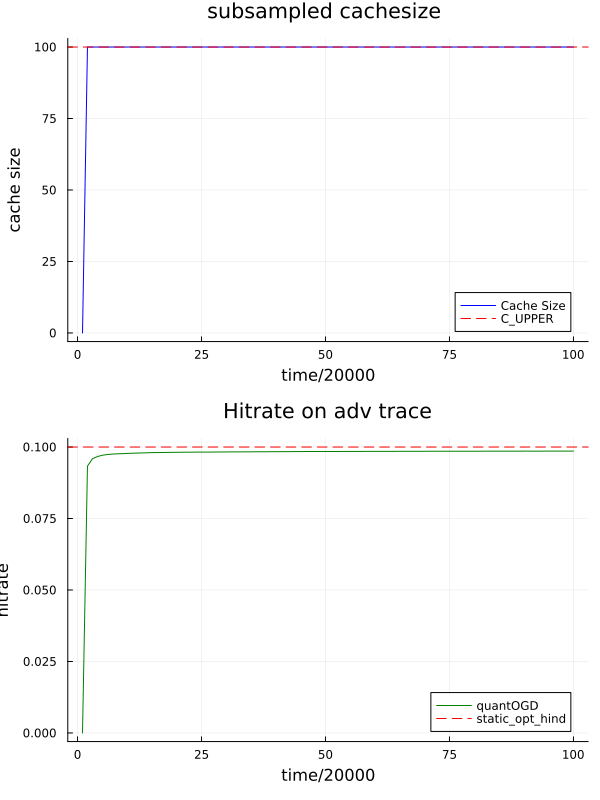

step_size: 1
final hitrate:0.098561


In [10]:
adv_hitrate_plt(rep= 2000, C = 100)

step_size: 2
final hitrate:0.1968285


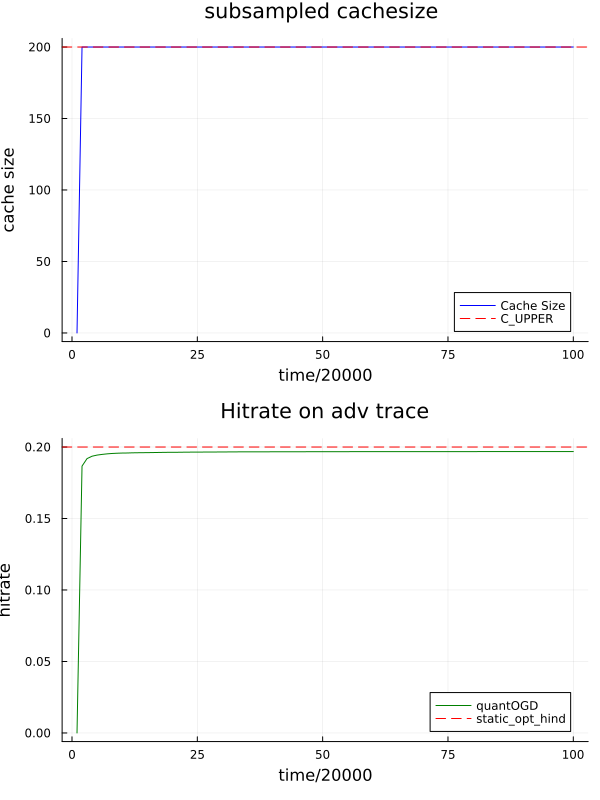

In [11]:
adv_hitrate_plt(rep= 2000, C = 200)

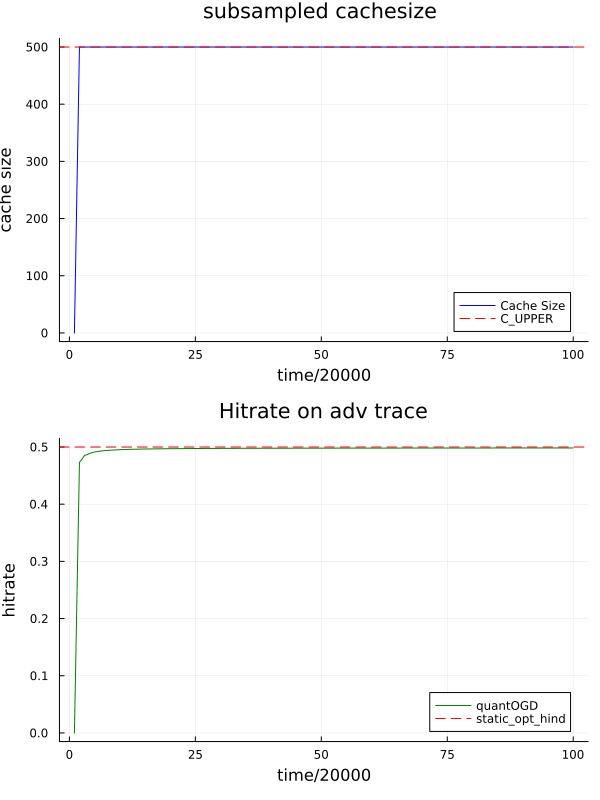

step_size: 2
final hitrate:0.498328


In [13]:
adv_hitrate_plt(rep= 2000, C = 500)